## feems

Ensure that your feems_env kernal is used to run this notebook. (https://github.com/NovembreLab/feems/blob/main/docsrc/notebooks/getting-started.ipynb) also see your other nb nobackup_uoo03627/qt_rat_sequencing/qt_rats_WG/scripts/claan927_51373117_.ipynb

In [1]:
import sys
print(sys.version)
!python --version

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) 
[GCC 7.5.0]
Python 3.11.3


def create_triangular_grid_for_bounds(input_shapefile, output_shapefile, cell_size=0.05):
    """
    Creates a triangular grid within the bounds of the input shapefile
    Using WGS 1984 coordinate system (degrees)
    """
    # Open the input shapefile
    driver = ogr.GetDriverByName("ESRI Shapefile")
    dataSource = driver.Open(input_shapefile, 0)
    
    if dataSource is None:
        print(f"Could not open {input_shapefile}")
        return
    
    layer = dataSource.GetLayer()
    
    # Get the extent of the shapefile
    extent = layer.GetExtent()
    xmin, xmax, ymin, ymax = extent[0], extent[1], extent[2], extent[3]
    print(f"Shapefile bounds: xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}")
    
    # Get the spatial reference of the input
    spatialRef = layer.GetSpatialRef()
    
    # Calculate height of equilateral triangle in degrees
    # For WGS84, the height will need adjustment since degrees of longitude vary with latitude
    # For a rough approximation that works for small areas:
    height = cell_size * np.sqrt(3) / 2
    
    # Create the output shapefile
    if os.path.exists(output_shapefile):
        driver.DeleteDataSource(output_shapefile)
    
    outDataSource = driver.CreateDataSource(output_shapefile)
    outLayer = outDataSource.CreateLayer("triangular_grid", spatialRef, ogr.wkbPolygon)
    
    # Add ID field
    idField = ogr.FieldDefn("ID", ogr.OFTInteger)
    outLayer.CreateField(idField)
    
    # Generate triangles
    cell_id = 0
    
    # Number of cells in each direction
    nx = int((xmax - xmin) / cell_size) + 1
    ny = int((ymax - ymin) / height) + 1
    
    print(f"Creating grid with {nx}x{ny} cells...")
    
    for i in range(ny - 1):
        if i % 10 == 0:
            print(f"Processing row {i}/{ny-1}...")
            
        for j in range(nx - 1):
            # Base coordinates
            x = xmin + j * cell_size
            y = ymin + i * height
            
            # Create first triangle (pointing up)
            ring = ogr.Geometry(ogr.wkbLinearRing)
            if (i + j) % 2 == 0:
                ring.AddPoint(x, y)
                ring.AddPoint(x + cell_size, y)
                ring.AddPoint(x + cell_size/2, y + height)
            else:
                ring.AddPoint(x, y)
                ring.AddPoint(x + cell_size, y)
                ring.AddPoint(x + cell_size/2, y - height)
            ring.CloseRings()
            
            poly = ogr.Geometry(ogr.wkbPolygon)
            poly.AddGeometry(ring)
            
            # Add to layer
            outFeature = ogr.Feature(outLayer.GetLayerDefn())
            outFeature.SetGeometry(poly)
            outFeature.SetField("ID", cell_id)
            outLayer.CreateFeature(outFeature)
            outFeature = None
            cell_id += 1
            
            # Create second triangle (pointing down)
            ring = ogr.Geometry(ogr.wkbLinearRing)
            if (i + j) % 2 == 0:
                ring.AddPoint(x, y)
                ring.AddPoint(x + cell_size/2, y + height)
                ring.AddPoint(x - cell_size/2, y + height)
            else:
                ring.AddPoint(x + cell_size, y)
                ring.AddPoint(x + cell_size/2, y - height)
                ring.AddPoint(x + 1.5*cell_size, y - height)
            ring.CloseRings()
            
            poly = ogr.Geometry(ogr.wkbPolygon)
            poly.AddGeometry(ring)
            
            # Add to layer
            outFeature = ogr.Feature(outLayer.GetLayerDefn())
            outFeature.SetGeometry(poly)
            outFeature.SetField("ID", cell_id)
            outLayer.CreateFeature(outFeature)
            outFeature = None
            cell_id += 1
    
    # Clean up
    dataSource = None
    outDataSource = None
    
    print(f"Created triangular grid with {cell_id} cells at {output_shapefile}")
    return output_shapefile

# Example usage
input_shapefile = "/nesi/nobackup/uoo03627/qt_rat_sequencing/feems/SI_grid/POLYLINE.shp"  # Your NZ boundary shapefile
output_shapefile = "/nesi/nobackup/uoo03627/qt_rat_sequencing/feems/SI_grid/NZ_triangular_grid.shp"

# For WGS84 (degrees), 0.01 degrees is about 1.1 km at NZ's latitude
create_triangular_grid_for_bounds(input_shapefile, output_shapefile, cell_size=0.01)

In [2]:
#imports
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from pathlib import Path

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

print ("Completed")

Completed


In [3]:
# all south island samples
data_path = Path("/nesi/nobackup/uoo03627/qt_rat_sequencing/RRATTUS_ALL_SI/results/09_genotyped_GATK/plinkpca")
prefix = "allvariants_gatk_dp_m05_pca_subsample1_10k_sorted"

In [4]:
# Next we read the plink formatted genotype data and impute any missing SNPs with the mean at each SNP: (thiis is in their pipeline so try this first)

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink(str(data_path / prefix))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))
print("Done")

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 20.71it/s]


n_samples=79, n_snps=10000
Done


In [5]:
%%time
# setup graph
feems_path = "/nesi/nobackup/uoo03627/qt_rat_sequencing/feems"

print("reading coords")
coord = np.loadtxt("{}/rats_coords_SI_nonames2.txt".format(feems_path))  # sample coordinates, no names, in order they are in the vcf
print("reading poly")
outer = np.loadtxt("{}/SI_polygon.outer".format(feems_path))  # outer coordinates
print("reading shp")
grid_path = "{}/SI_grid/NZ_triangular_grid_0.5.shp".format(feems_path)  # path to discrete global grid, WGS84

reading coords
reading poly
reading shp
CPU times: user 797 µs, sys: 1.91 ms, total: 2.71 ms
Wall time: 2.78 ms


In [6]:
%%time
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                          ggrid=grid_path,
                                          translated=False, 
                                          buffer=0,
                                          outer=outer)

print("Done")

Done
CPU times: user 232 ms, sys: 3.78 ms, total: 236 ms
Wall time: 266 ms


In [7]:
outer[:5, ]

array([[172.67472833, -40.38129139],
       [174.02758702, -40.65937591],
       [174.49578194, -41.08188572],
       [174.28538794, -41.86161987],
       [172.84210757, -43.45196686]])

In [8]:
edges[:5, ]

array([[47, 53],
       [64, 69],
       [67, 68],
       [25, 32],
       [42, 48]])

In [9]:
grid[:5, ]

array([[167.237, -46.967],
       [167.737, -46.967],
       [168.237, -46.967],
       [166.987, -46.534],
       [167.487, -46.534]])

# Spatial graph

In [10]:
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)
print("Done")

Done


In [11]:
# projection from cartopy's coordinate reference system (ccrs) module, centered in the middle of the south island of nz near Peel Forest, -43.644076, 170.786516
#projection = ccrs.EquidistantConic(central_longitude=170.786516, central_latitude=-43.644076)
projection = ccrs.Orthographic(central_longitude=170.786516, central_latitude=-43.644076)

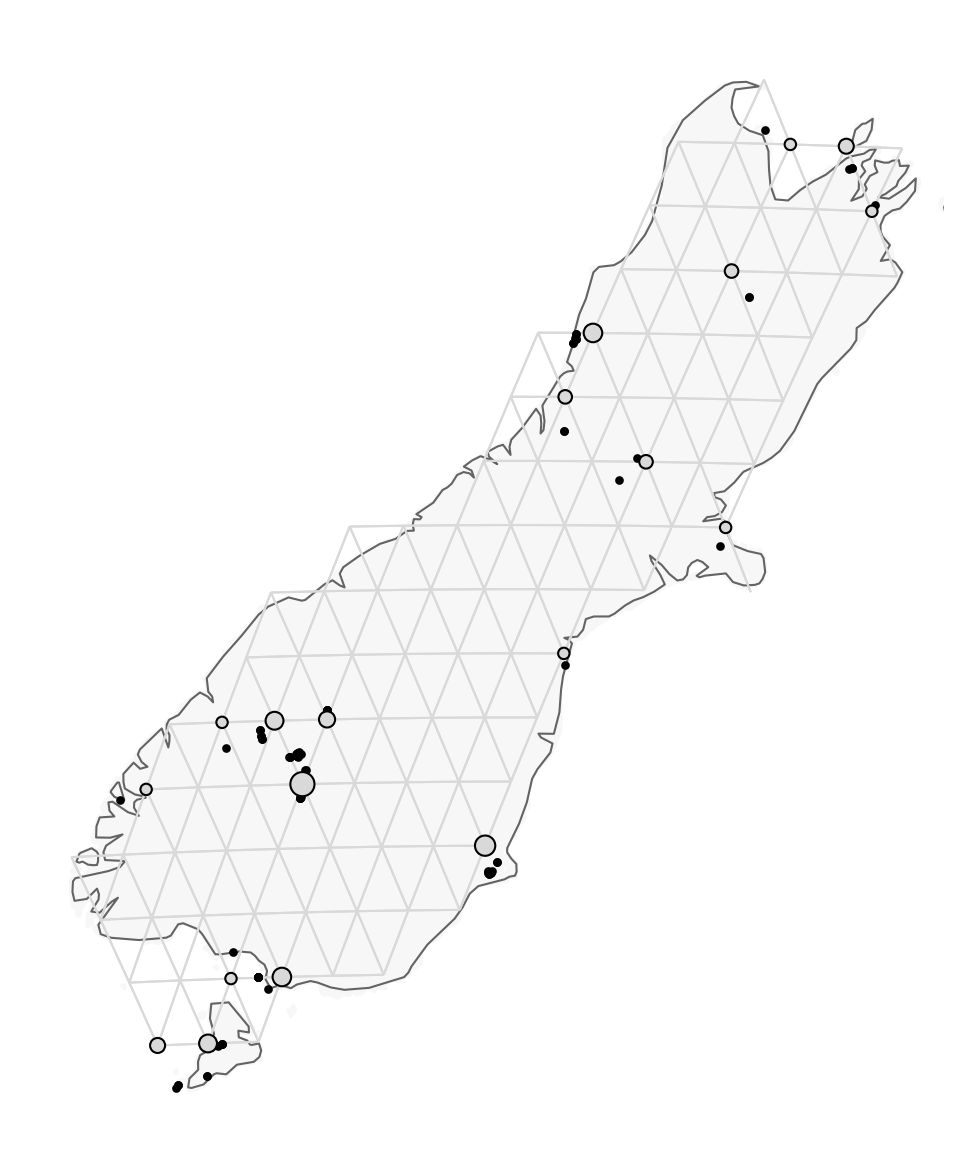

In [12]:
# we first of all visualise the graph and sample locations. The black points are the observed locations for each sample and the grey points show the nodes theyy were assigned to. 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

# Fit FEEMS

In [13]:
# large lambda (regularization/smoothing parameter)
sp_graph.fit(lamb = 20.0)

constant-w/variance fit, converged in 147 iterations, train_loss=95027.9665281
lambda=20.0000000, alpha=0.2793107, converged in 55 iterations, train_loss=86399.3980202


TypeError: draw_edge_colorbar() got an unexpected keyword argument 'location'

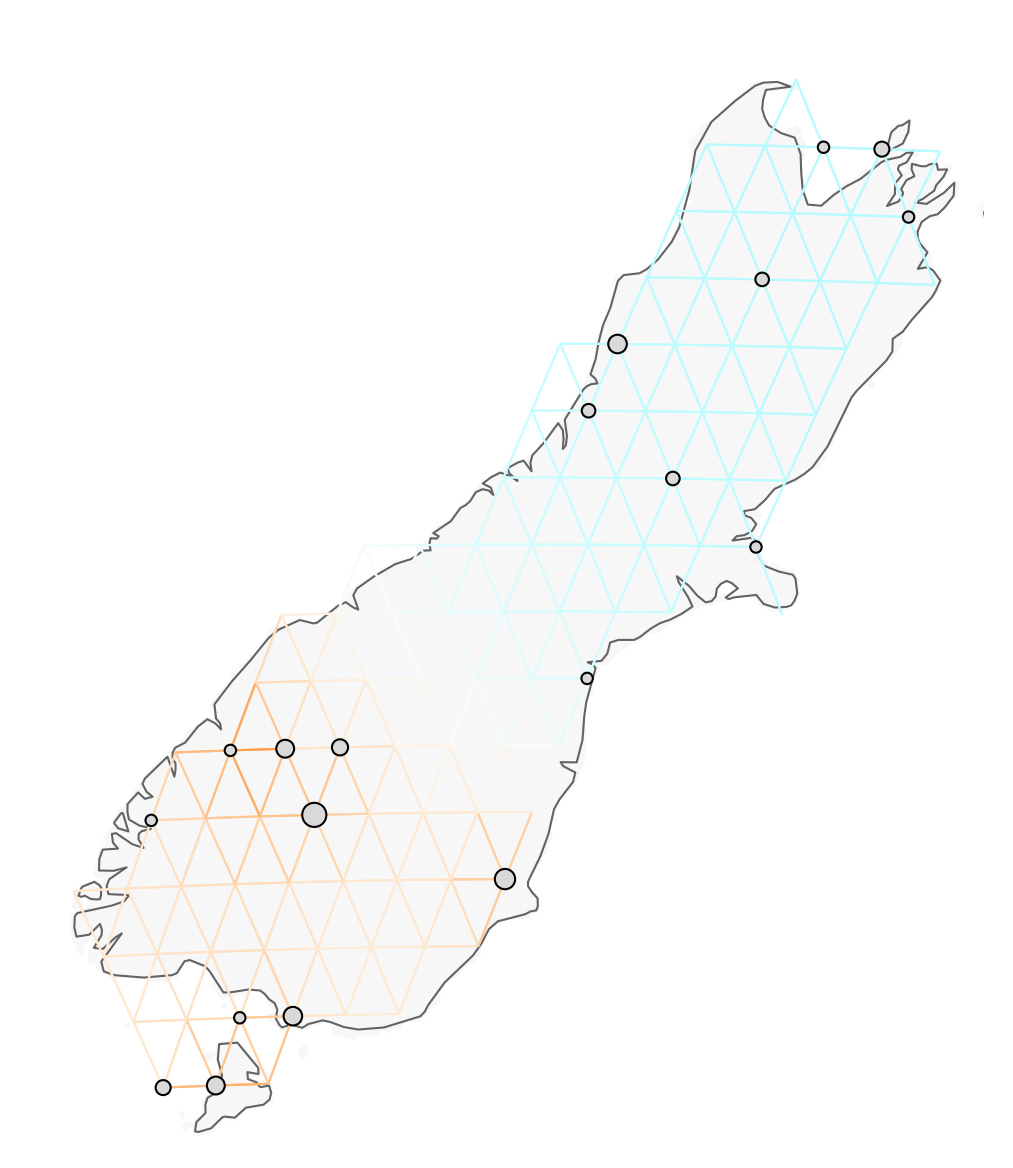

In [14]:
# visualise the weighted graph
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar(location='right')


TypeError: draw_edge_colorbar() got an unexpected keyword argument 'right'

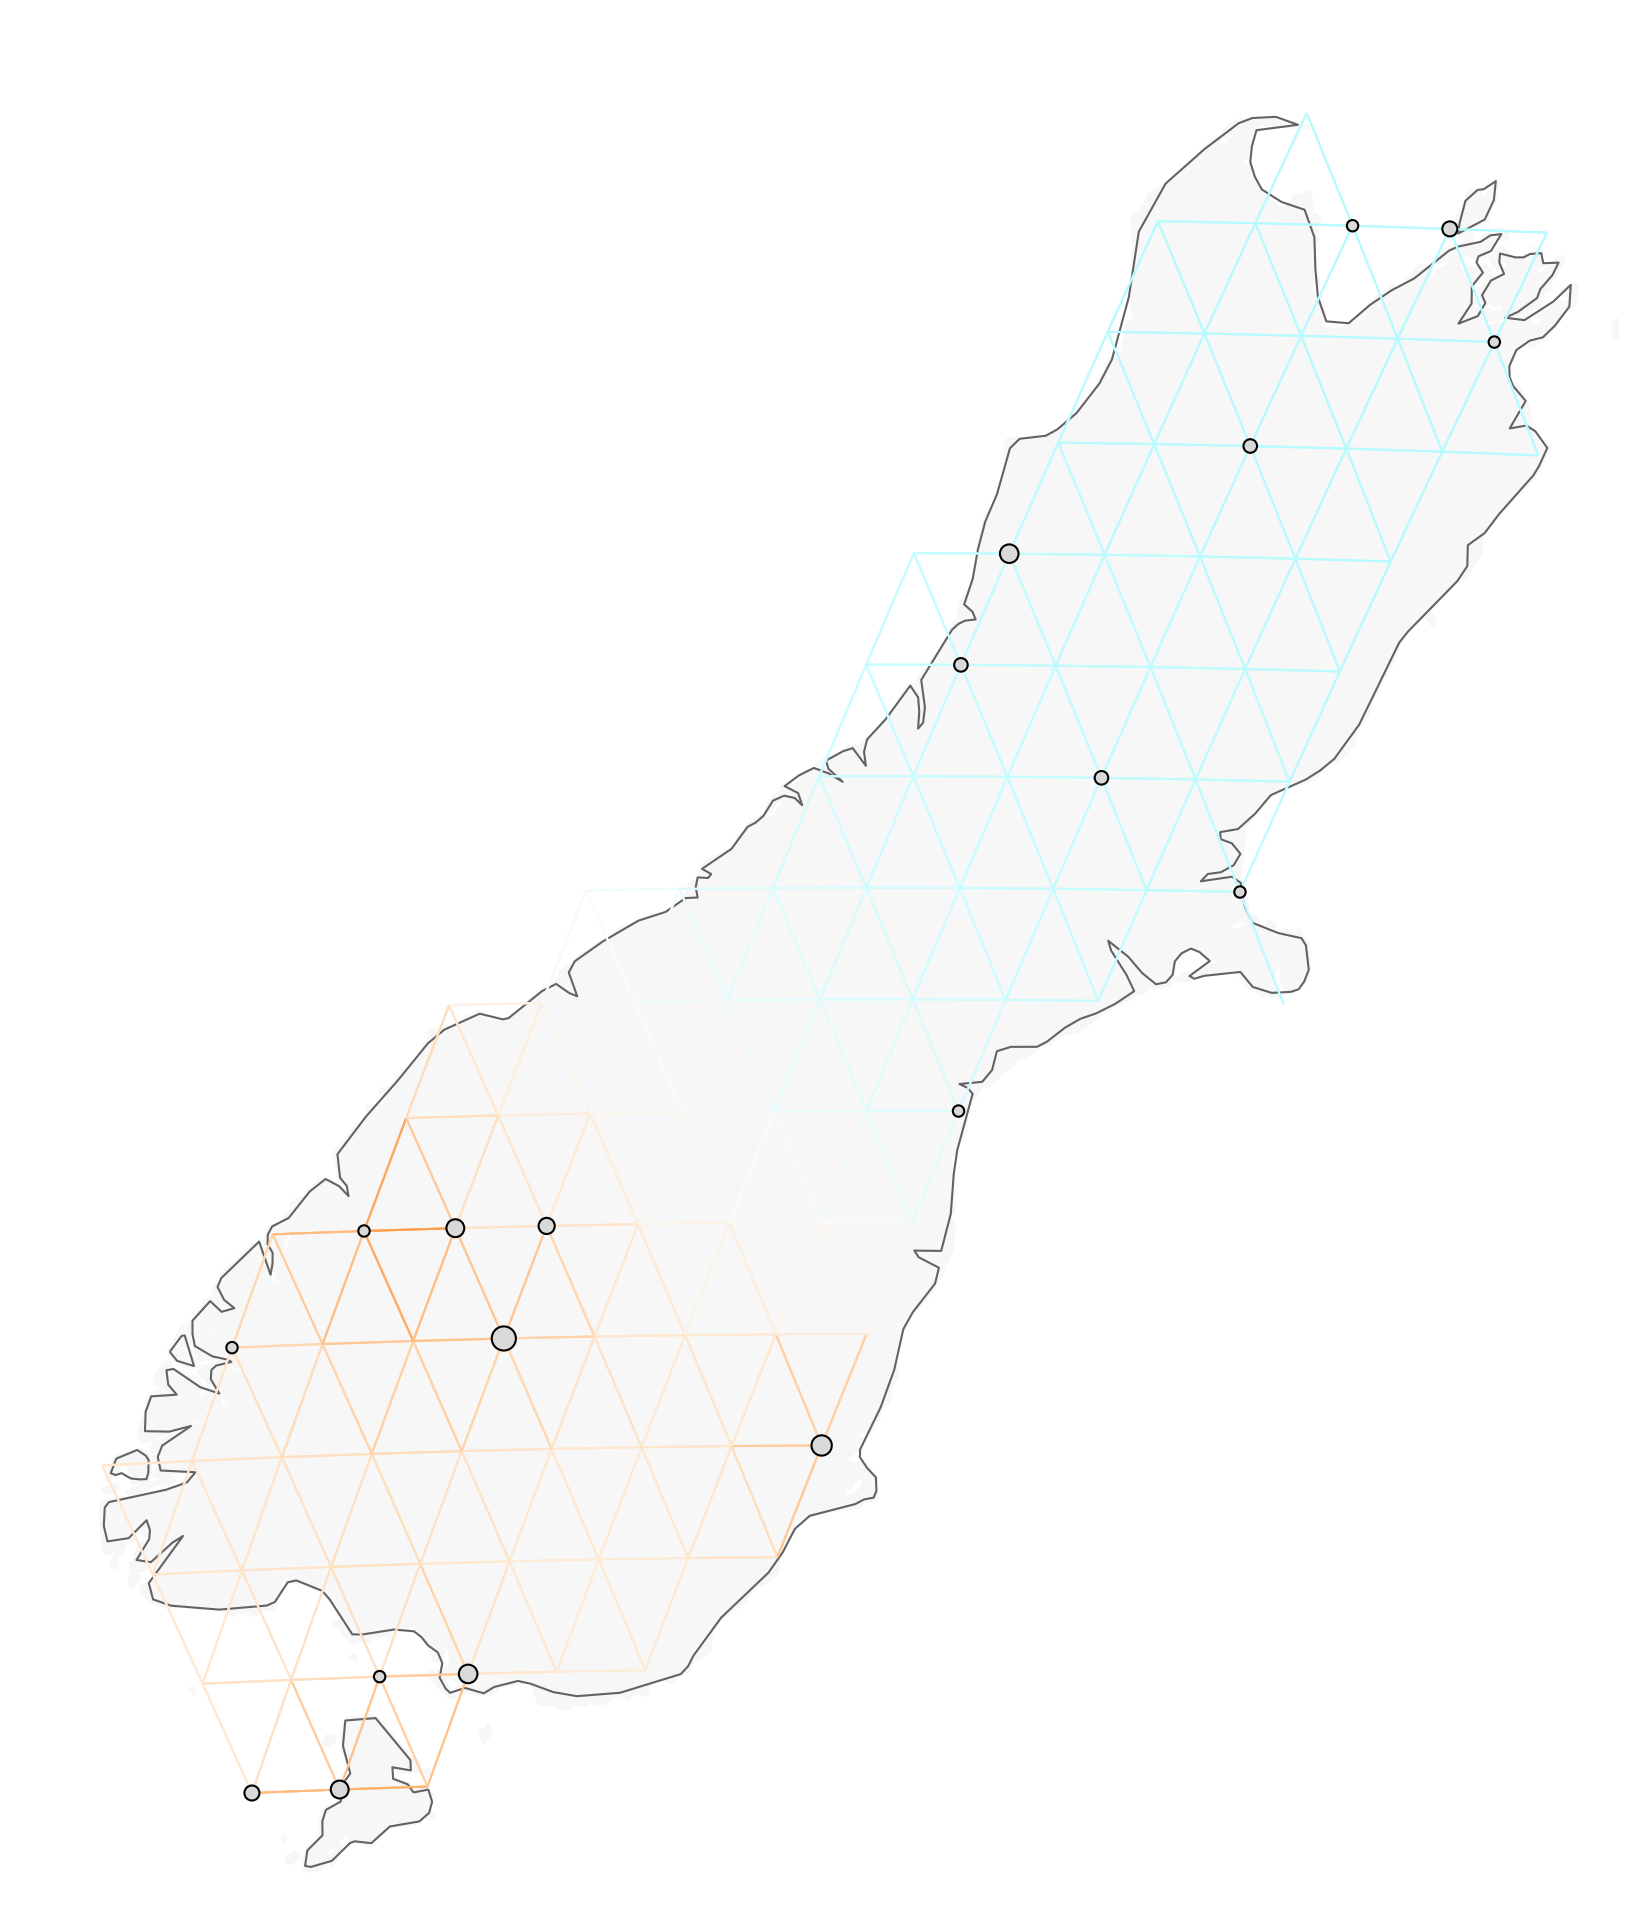

In [15]:
# we need to fix the positioning of the colourbar
# Create your plot as normal
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)

v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

# Instead of creating a new colorbar, capture the existing one
cbar = v.draw_edge_colorbar(right=0.8)

# Try to directly modify the figure layout to make room for the colorbar
# Adjust the main plot area to leave space at bottom right
plt.subplots_adjust(right=0.8, bottom=0.2)

In [16]:
# more detail with a much smaller lambda
sp_graph.fit(lamb = 2.0)

constant-w/variance fit, converged in 147 iterations, train_loss=95027.9665281
lambda=2.0000000, alpha=0.2793107, converged in 49 iterations, train_loss=83279.1026754


NameError: name 'right' is not defined

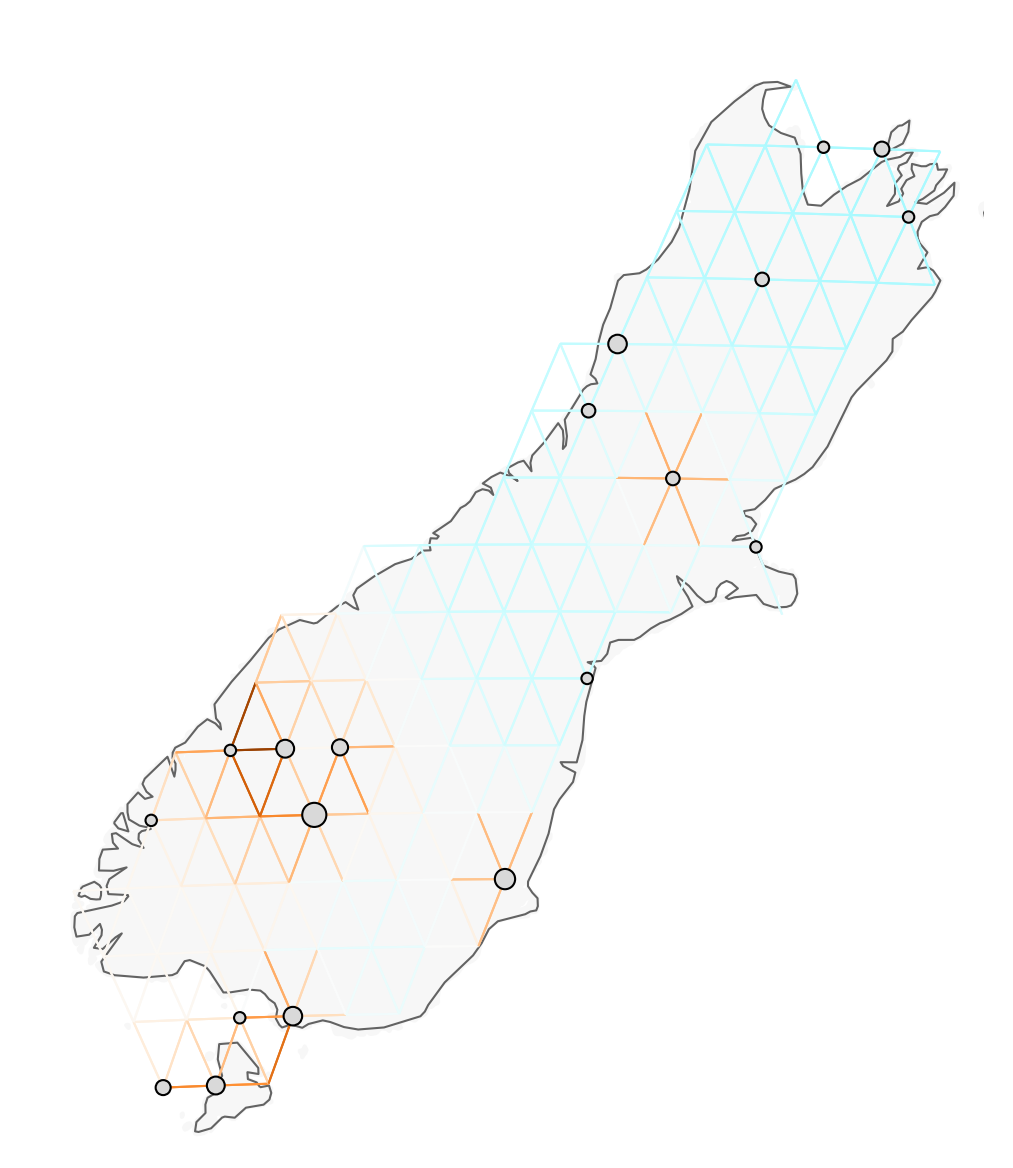

In [17]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar(right)

In [18]:
# more detail with a much smaller lambda
sp_graph.fit(lamb = 1.0)

constant-w/variance fit, converged in 147 iterations, train_loss=95027.9665281
lambda=1.0000000, alpha=0.2793107, converged in 58 iterations, train_loss=82198.7433971


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


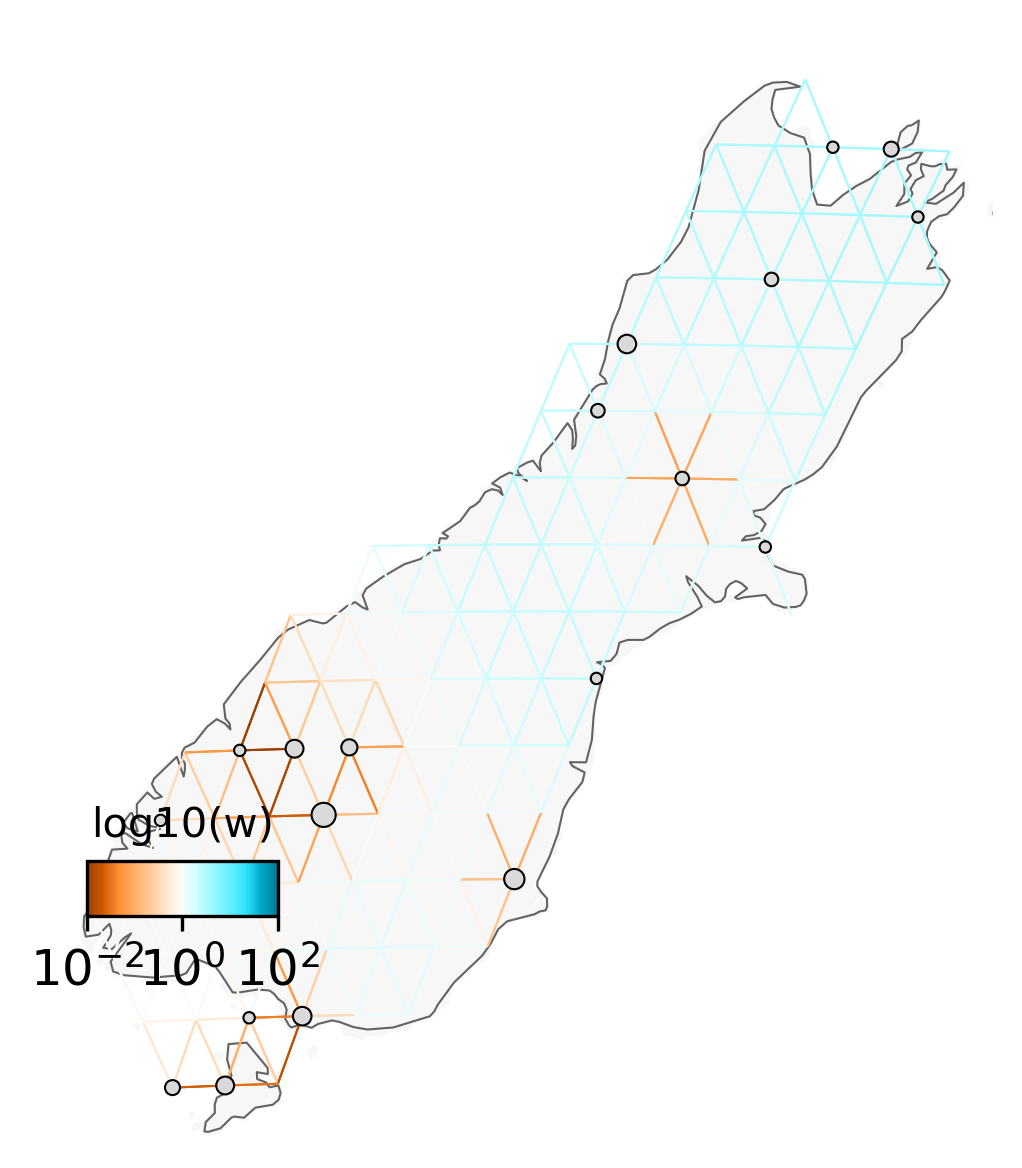

In [19]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

# Fit feems with cross-validation

In [ ]:
#fit FEEMS across a grid of possible regularization values and choose the one that minimizes the cross-validation error. This will take approximately 15 minutes on a single CPU.

In [21]:
# downgrade pandas b/c its playing up
!pip install pandas==1.2.5

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-1.2.5.tar.gz (5.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pandas (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1494 lines of output]
      <string>:44: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
      running bdist_wheel
      running build
      running build_py
      creating build/lib.linux-x86_64-cpython-311/pandas
      copying pandas/testing.py -> build/lib.linux-x86_64-cpython-311/pandas
      copying pandas/conftest.py -> build/lib.linux-x86_64-cpython-311/pandas
      copying pandas/_version.py -> build/lib.linux-x86_64-cpython-311/pandas
      copying pandas/_typing.py -> build/lib.linux-x86_64-cpython-311/pandas
      copying pandas/_testing.py ->

In [23]:
pip install --upgrade statsmodels

Note: you may need to restart the kernel to use updated packages.


In [24]:
%%time
import pandas as pd
import sys

if not hasattr(pd, 'Int64Index'):
    pd.Int64Index = pd.Index
    sys.modules['pandas'].Int64Index = pd.Index

import math
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
import pickle

# viz
from matplotlib import gridspec

# feems
from feems import Objective, query_node_attributes
from feems.cross_validation import run_cv, comp_mats

def cov_to_dist(S):
    s2 = np.diag(S).reshape(-1, 1)
    ones = np.ones((s2.shape[0], 1))
    D = s2 @ ones.T + ones @ s2.T - 2 * S
    return(D)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1325, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 11, in <module>
  File "/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/statsmodels/api.py", line 79, in <module>
    from .__init__ import test
  File "/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/statsmodels/__init__.py", line 1, in <module>
    from statsmodels.compat.patsy import monkey_patch_cat_dtype
  File "/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/statsmodels/compat/patsy.py", line 1, in <module>
    from statsmodels.compat.pandas import PD_LT_2
ImportError: cannot import name 'PD_LT_2' from 'statsmodels.compat.pandas' (/scale_wl

In [26]:
%%time
LoadCVFromDisk = True

# define grid
# Publication grid for this dataset
#lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
# Exploratory grid: i.e. test 10 lambda values between 0.0001 and 10
lamb_grid = np.geomspace(1e-4, 1e1, 10)[::-1]

# run cross-validation
if not LoadCVFromDisk:
    cv_err = run_cv(sp_graph, lamb_grid, n_folds=sp_graph.n_observed_nodes, factr=1e10)
    pickle.dump(cv_err,open("/nesi/nobackup/uoo03627/qt_rat_sequencing/feems/cv_err.pkl","wb"))

CPU times: user 279 µs, sys: 128 µs, total: 407 µs
Wall time: 413 µs


In [ ]:
# plot the cross validation error and use the lambda at the elbow on the plot (lowest L2 CV Error value). 

In [28]:
import pickle
LoadCVFromDisk = True
if LoadCVFromDisk: 
    cv_err = pickle.load(open("/nesi/nobackup/uoo03627/qt_rat_sequencing/feems/cv_err.pkl","rb"))
    
# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

fig, ax = plt.subplots(dpi=300)
ax.plot(np.log10(lamb_grid), mean_cv_err, ".");
ax.set_xlabel("log10(lambda)");
ax.set_ylabel("L2 CV Error");
ax.axvline(np.log10(lamb_cv), color = "orange")
lamb_cv


FileNotFoundError: [Errno 2] No such file or directory: '/nesi/nobackup/uoo03627/qt_rat_sequencing/feems/cv_err.pkl'

In [ ]:
#refit the model the lambda we found above that minimizes the cross-validation error ('lamb_cv'), and plot the result.

In [ ]:
# re-fit
sp_graph.fit(lamb_cv)

# Plot the FEEMS result
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()